# 이미지 어디까지 우려볼까?

## Augmentation 적용 (1) - 데이터 불러오기

augmentation을 텐서플로우 모델 학습에 어떻게 적용할 수 있는지 공부하겠습니다. 지금까지 모델을 훈련시키기 전, 데이터를 전처리해 입력값으로 사용해 오셨을 것입니다. Augmentation도 이처럼 입력 이미지의 데이터를 변경해주는 과정이므로 일반적인 이미지 데이터 전처리 방법과 활용방법이 동일합니다. 먼저 필요한 라이브러리들을 불러와 줍니다.

tensorflow_datasets가 설치되어 있지 않다면, 아래 명령어로 설치해 주세요.

```bash
$ pip install tensorflow_datasets
```



In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

GPU 환경을 확인해 주세요.



In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

그리고 사용할 데이터셋을 불러옵니다. 이번 시간에는 `stanford_dogs` 데이터셋을 사용해보도록 합시다. stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함되어 있습니다. 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋입니다.


데이터를 처음 사용한다면 다운로드 받아야 하기 때문에 시간이 오래(10분 이상) 걸릴 수 있습니다. 데이터셋은 다른 프로젝트에서도 사용할 수 있으니 프로젝트 디렉토리가 아닌 TensorFlow Datasets 기본 디렉토리에 저장합시다.

- <https://www.tensorflow.org/datasets/catalog/stanford_dogs>

In [4]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


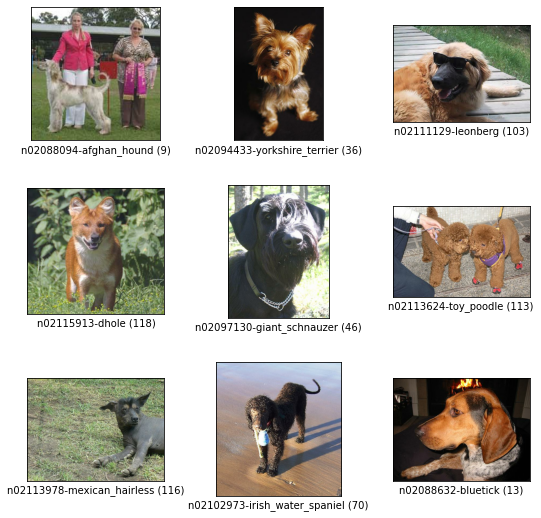

In [5]:
fig = tfds.show_examples(ds_info, ds_train)

## Augmentation 적용 (2) Augmentation 적용하기


### 텐서플로우 Random Augmentation API 사용하기

많은 augmentation 기법들이 있지만 그 중에서 텐서플로우 API로 바로 사용할 수 있는 방법들을 먼저 적용해 보겠습니다. 먼저 이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들은 아래와 같습니다.

- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()

그럼, Augmentation을 적용하기에 앞서 기본적인 전처리 함수를 만들어 줍시다.

In [6]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255, label

이미지를 변환하는 전처리 함수는 대략 다음과 같은 형태를 가지게 됩니다.

```python
def 전처리_함수(image, label):   # 변환할 이미지와 
    # 이미지 변환 로직 적용
        new_image = 이미지_변환(image)
    return new_image, label
```

이렇게 되면 이미지 변환의 결과로 리턴받은 이미지를 그 다음 전처리 함수의 입력으로 연거푸 재사용할 수 있는 구조가 되어 편리합니다. 위에서 만든 기본적인 전처리 함수도 위와 같은 구조를 가지고 있습니다. 이 함수는 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize합니다. 이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용될 것입니다.

맨 위에서 언급한 random augmentation들 중에서 `random_flip_left_right()`과 `random_brightness()`를 활용해 보겠습니다. "flip"의 경우 좌우 대칭을 해줍니다. 예컨대 이미지 분류 문제에서 개 이미지는 좌우를 대칭하더라도 문제가 생기지 않습니다. 따라서 좌우대칭의 적용을 통해 데이터를 늘릴 수 있도록 합니다. 여기서 상하대칭은 테스트 데이터셋의 이미지를 생각해볼 때 위아래가 뒤집힌 사진이 없으므로 도움이 되지 않을 것이라 적용하지 않습니다. 또 "brightness"를 조절하여 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 하겠습니다.

In [7]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    return image, label

오늘의 Augmentation을 통해 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수를 `apply_normalize_on_dataset()`로 정의하겠습니다.

여기서는 `apply_normalize_on_dataset()`를 통해서 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용하도록 하겠습니다. 이때 주의해야할 점은 shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 한다는 점입니다.


> 여러 결과를 조합하기 위한 앙상블(ensemble) 방법 중 하나로 테스트 데이터셋에 augmentation을 적용하는 test-time augmentation이라는 방법이 있습니다. 이는 캐글 등의 경쟁 머신러닝에 많이 사용되지만, 지금은 개념만 알아두어도 됩니다. 아래 링크에서 test-time augmentation에 관한 설명을 참고하세요. <br/>[hwiyong님의 TTA(test time augmentation) with 케라스](https://hwiyong.tistory.com/215)

참고로, 이후에 수행할 비교실험을 위해서 `with_aug` 매개변수를 통해 augmentation의 적용여부를 결정할 수 있도록 하겠습니다.

- [참고: tf.data.Datasets.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)



In [8]:
# 데이터셋(ds)를 가공하는 메인 함수
def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16, with_aug = False):
    ds = ds.map(
        normalize_and_resize_img, # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    
    if not is_test and with_aug:
        ds = ds.map(
            augment, # augment 함수 적용
            num_parallel_calls=2
        )
    
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### Random Augmentation 직접 구현하기

위에서는 미리 구현된 random augmentation을 적용하도록 augment() 함수를 작성했습니다. 이번에는 tf.image의 다양한 함수들을 이용해서 직접 다양한 augmentation 기법을 랜덤하게 적용하는 `augment2()` 함수를 작성해봅시다.

In [9]:
def augment2(image, label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, INPUT_SHAPE)
    return image, label

## Augmentation 적용 (3) - 비교 실험하기

이제 비교실험을 해보도록 하겠습니다. 우리가 비교해야 하는 것은 augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능입니다. 새로운 augmentation이 떠오르셨다면 새로운 함수로 augmentation한 데이터와 아닌 데이터를 학습시켜서 어떤 효과가 있는지 실험을 통해 알아볼 수도 있습니다.

아래 코드는 텐서플로우 케라스의 `ResNet50` 중 `imagenet`에 훈련된 모델을 불러옵니다. `include_top`은 마지막 fully connected layer를 포함할지 여부입니다. 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다. 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문입니다.

In [10]:
num_classes = ds_info.features['label'].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg'
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어줍니다.

In [11]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

텐서플로우 데이터셋에서 불러온 데이터에 하나는 `apply_normalize_on_dataset()`에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.



In [12]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split = ['train', 'test'],
    as_supervised = True,
    shuffle_files = True,
    with_info = True
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug = False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

이제 두 개 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행합니다.



In [ ]:
tf.random.set_seed(2020)

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 1829s 2s/step - loss: 2.2232 - accuracy: 0.4471 - val_loss: 3.1922 - val_accuracy: 0.2231
Epoch 2/10
205/750 [=======>......................] - ETA: 19:33 - loss: 1.0068 - accuracy: 0.7137

In [ ]:
tf.random.set_seed(2020)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)